In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Mean scaling

In [24]:
df = pd.read_csv('https://raw.githubusercontent.com/marcopeix/time-series-analysis/master/data/medium_views_published_holidays.csv')
df['ds'] = pd.to_datetime(df['ds'])

df.head()

,unique_id,ds,y,published,is_holiday
0,0,2020-01-01,1131,0.0,1
1,0,2020-01-02,1764,0.0,0
2,0,2020-01-03,1699,0.0,0
3,0,2020-01-04,1322,0.0,0
4,0,2020-01-05,1491,0.0,0


In [25]:
def mean_scaling(x):
    mean = np.mean(np.abs(x))

    return x/mean

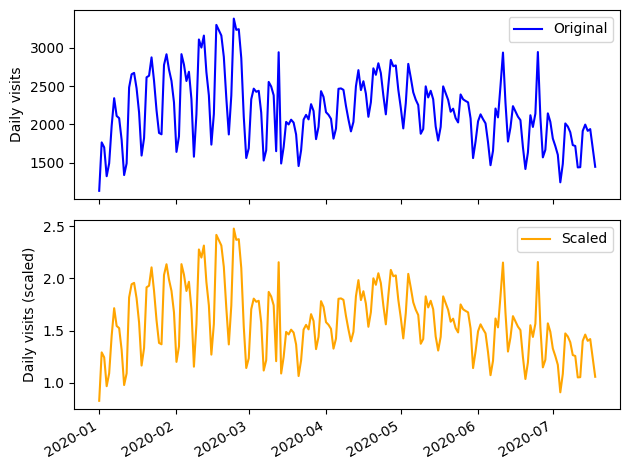

In [26]:
y = df['y'].values
y_scaled = mean_scaling(y)

fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2)

ax1.plot(df['ds'][:200], y[:200], color='blue', label='Original')
ax1.set_ylabel('Daily visits')
ax1.legend()

ax2.plot(df['ds'][:200], y_scaled[:200], color='orange', label='Scaled')
ax2.set_ylabel('Daily visits (scaled)')
ax2.legend()

fig.autofmt_xdate()
plt.tight_layout()

## Quantization

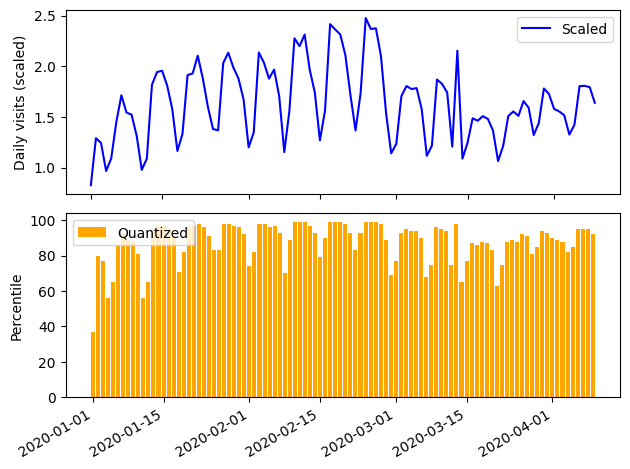

In [27]:
bins = pd.qcut(y_scaled, q=100, labels=False)

fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2)

ax1.plot(df['ds'][:100], y_scaled[:100], color='blue', label='Scaled')
ax1.set_ylabel('Daily visits (scaled)')
ax1.legend()

ax2.bar(df['ds'][:100], bins[:100], color='orange', label='Quantized')
ax2.set_ylabel('Percentile')
ax2.legend()

fig.autofmt_xdate()
plt.tight_layout()

## Forecasting with Chronos

In [28]:
import time
from datasetsforecast.m3 import M3
from utilsforecast.losses import *
from utilsforecast.evaluation import evaluate
import torch
from chronos import ChronosPipeline

Y_df, *_ = M3.load(directory='./', group='Monthly')

In [29]:
pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-large",
  device_map="cuda",
  torch_dtype=torch.bfloat16,
)

horizon = 12

actual = []
preds = []

start = time.time()
for i in range(1, 1429):
    df = Y_df[Y_df['unique_id'] == f"M{i}"]

    actual.extend(df['y'][-horizon:].values)

    context = torch.tensor(df['y'].iloc[:-horizon].values)

    forecast = pipeline.predict(context, horizon)
    predictions = np.quantile(forecast[0].numpy(), [0.5], axis=0)

    preds.extend(predictions[0])

chronos_duration = time.time() - start

results_df = pd.DataFrame({
    'target': actual,
    'chronos': preds
})

print(chronos_duration)

1197.8377211093903


### Testing N-BEATS and MLP

In [11]:
from neuralforecast.models import MLP, NBEATS
from neuralforecast.losses.pytorch import HuberLoss
from neuralforecast.core import NeuralForecast

horizon = 12
val_size = 12
test_size = 12

mlp = MLP(h=horizon, input_size=3*horizon, loss=HuberLoss(), devices=1, accelerator='cpu')

start = time.time()
nf = NeuralForecast(models=[mlp], freq='M')
mlp_forecasts_df = nf.cross_validation(df=Y_df, val_size=val_size, test_size=test_size, n_windows=None, verbose=True)

mlp_duration = time.time() - start

mlp_forecasts_df.head()

print(mlp_duration)

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 178.75it/s]
35.88944435119629


In [12]:
nbeats = NBEATS(h=horizon, input_size=3*horizon, loss=HuberLoss(), devices=1, accelerator='cpu')

start = time.time()
nf = NeuralForecast(models=[nbeats], freq='M')
nbeats_forecasts_df = nf.cross_validation(df=Y_df, val_size=val_size, test_size=test_size, n_windows=None, verbose=True)

nbeats_duration = time.time() - start

nbeats_forecasts_df.head()

print(mlp_duration)

INFO:lightning_fabric.utilities.seed:Seed set to 1


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 127.63it/s]
35.88944435119629


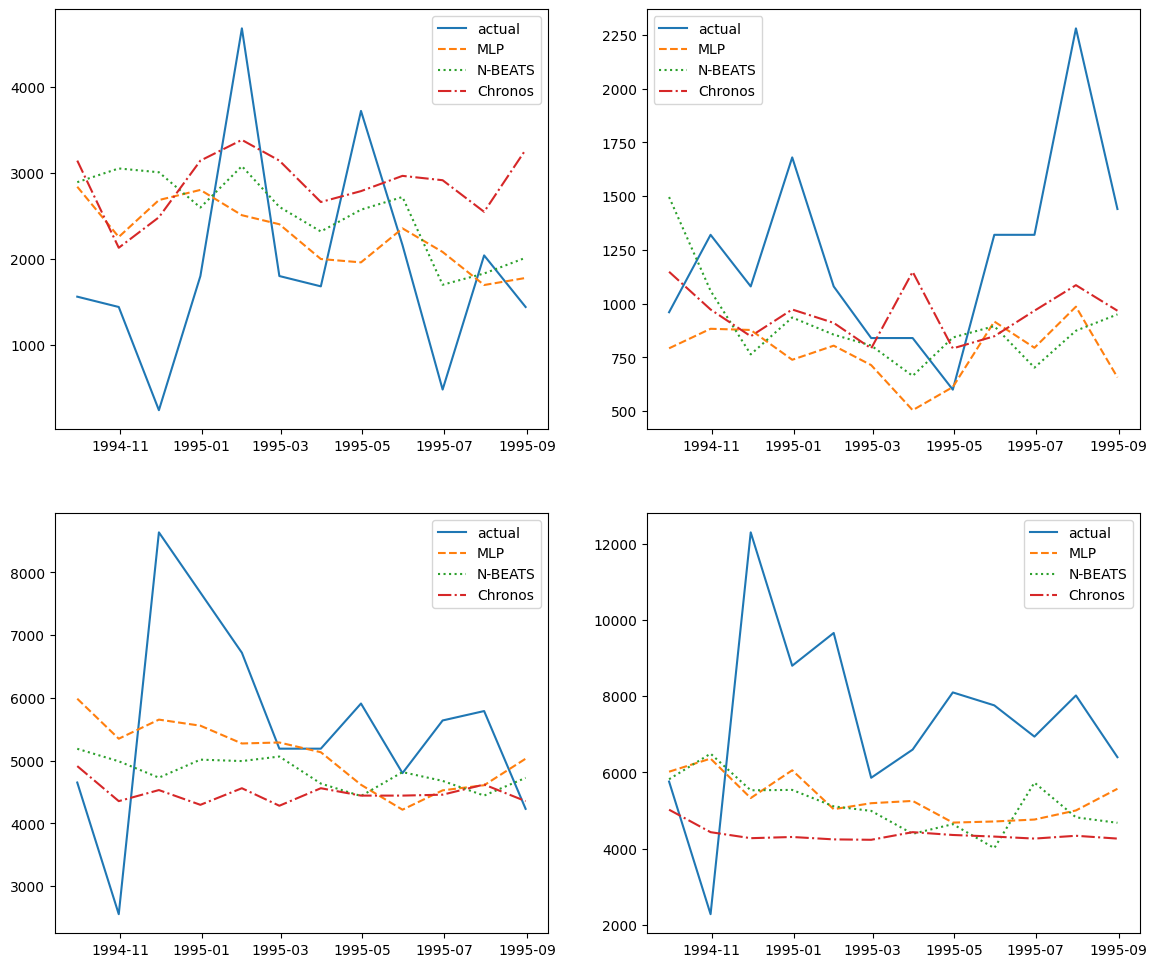

In [35]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,12))

for i, ax in enumerate(axes.flatten()):
    id = f"M{i+1}"
    mlp_to_plot = mlp_forecasts_df[mlp_forecasts_df['unique_id'] == id]
    nbeats_to_plot = nbeats_forecasts_df[nbeats_forecasts_df['unique_id'] == id]

    ax.plot(mlp_to_plot['ds'], mlp_to_plot['y'], label='actual')
    ax.plot(mlp_to_plot['ds'], mlp_to_plot['MLP'], ls='--', label='MLP')
    ax.plot(nbeats_to_plot['ds'], nbeats_to_plot['NBEATS'], ls=':', label='N-BEATS')
    ax.plot(nbeats_to_plot['ds'], preds[0+12*i:12+12*i], ls='-.', label='Chronos')

    ax.legend()

### Evaluation

In [38]:
from neuralforecast.losses.numpy import mae, smape

mlp_mae = mae(mlp_forecasts_df['y'], mlp_forecasts_df['MLP'])
mlp_smape = smape(mlp_forecasts_df['y'], mlp_forecasts_df['MLP'])

nbeats_mae = mae(nbeats_forecasts_df['y'], nbeats_forecasts_df['NBEATS'])
nbeats_smape = smape(nbeats_forecasts_df['y'], nbeats_forecasts_df['NBEATS'])

chronos_mae = mae(results_df['target'], results_df['chronos'])
chronos_smape = smape(results_df['target'], results_df['chronos'])

data = {
    'MLP': [mlp_mae, mlp_smape],
    'NBEATS': [nbeats_mae, nbeats_smape],
    'Chronos': [chronos_mae, chronos_smape]
}

metrics_df = pd.DataFrame(data=data)
metrics_df.index = ['mae', 'smape']

metrics_df.style.highlight_min(color='blue', axis=1)

,MLP,NBEATS,Chronos
mae,566.822735,556.521487,569.291770
smape,0.128473,0.126480,0.127191
